# [RAG in Practice] Experiment with 5 Advanced Retrieval in LlamaPacks

This notebook is the code implementation and performance comparison for 5 advanced RAG methods in LlamaPacks in the privious [video](https://www.bilibili.com/video/BV1qe411r78b/) publised in Bilili.

LlamaPacks: Building RAG in Fewer Lines of Code.

<a target="_blank" href="https://colab.research.google.com/drive/15ozcuZSvha0Fl2GSCj9p6ZUVIN8NCsB6">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Comparison conducted among the following advanced retrieval with Llamapacks.

- **Baseline: Naive query engine with Llamaindex**

- **Pack 1: Hybrid Fusion Retriever Pack** [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/hybrid_fusion/hybrid_fusion.ipynb) [[Source]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/hybrid_fusion/base.py)

Built on top of [QueryFusionRetriever](https://docs.llamaindex.ai/en/stable/examples/retrievers/simple_fusion.html). Generates multiple queries from the input question and then ensembles vector and bm25 retrievers using fusion(vector + keyword search + reciprocal_rerank_fusion)

- **Pack 2: Query Rewriting Retriever Pack** [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/query_rewrite/query_rewrite.ipynb) [[Source]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/query_rewrite/base.py)

Built on top of [QueryFusionRetriever](https://docs.llamaindex.ai/en/stable/examples/retrievers/simple_fusion.html). Rewrite(Generates) multiple queries from the input question, retrieve with vector search and rerank the results with reciprocal_rerank_fusion.

- **Pack 3: AutoMergingRetrieverPack pack** [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/auto_merging_retriever/auto_merging_retriever.ipynb) [Source](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/auto_merging_retriever/base.py)

Built on top of [AutoMergingRetriever](https://docs.llamaindex.ai/en/stable/examples/retrievers/auto_merging_retriever.html#auto-merging-retriever). It loads a document, builds a hierarchical node graph (with bigger parent nodes and smaller child nodes) and then check if enough children nodes of a parent node have been retrieved and merge and replace with that parent.

- **Pack 4: Small-to-big Retrieval Pack** [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/recursive_retriever/small_to_big/small_to_big.ipynb) [[Source]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/recursive_retriever/small_to_big/base.py)

Built on top of [RecursiveRetriever](https://docs.llamaindex.ai/en/stable/examples/query_engine/pdf_tables/recursive_retriever.html). Given input documents, and an initial set of "parent" chunks, subdivide each chunk further into "child" chunks.  Link each child chunk to its parent chunk, and index the child chunks.

- **Pack 5: Sentence Window Retrieval Pack** [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/auto_merging_retriever/auto_merging_retriever.ipynb) [[Source]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/sentence_window_retriever/base.py)

Built on top of [SentenceWindowNodeParser](https://docs.llamaindex.ai/en/stable/api/llama_index.node_parser.SentenceWindowNodeParser.html). It loads a document, split a document into Nodes, with each node being a sentence. Each node contains a window from the surrounding sentences in the metadata.




MODEL = "gpt-3.5-turbo"

*So, which one will perform best? My answer is: "It depends! Different retrieval tasks and datasets have varying requirements, and there's no one-size-fits-all solution. "*

**But for this use, the best performer is ...**

## Packages

In [ ]:
# !pip install llama-hub unstructured llama-index rank-bm25

In [ ]:
# !pip install transformers

In [ ]:
# !pip install torch torchvision

## Data Loading

We will use the [Tesla-10-K-2022-Filing](https://www.sec.gov/Archives/edgar/data/1318605/000095017023001409/tsla-20221231.htm) which has plenty of tables and texts. You can download it.



In [ ]:
# download data
!wget https://www.dropbox.com/scl/fi/fqyvmodovgk21p06giezu/Tesla-10-K-2022-Filing.html .

In [ ]:
qna_dict = {
        "What is the value of cash and cash equivalents in 2022?": "16,253 $ millions",
        "What is the value of cash and cash equivalents in 2021?": "17,576 $ millions",
        "What is the net value of accounts receivable in 2022?": "2,952 $ millions",
        "What is the net value of accounts receivable in 2021?": "1,913 $ millions",
        "What is the total stockholders' equity? in 2022?": "44,704 $ millions",
        "What is the total stockholders' equity? in 2021?": "30,189 $ millions",
        "What are total operational expenses for research and development in 2022?": "3,075 $ millions",
        "What are total operational expenses for research and development in 2021?": "2,593 $ millions",
    }

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass()


 ········


In [ ]:
from llama_hub.file.unstructured.base import UnstructuredReader
from pathlib import Path
from llama_index import Document
from llama_index.node_parser import SimpleNodeParser

loader = UnstructuredReader()
documents = loader.load_data(
        file=Path(f"./Tesla-10-K-2022-Filing.html")
    )

# parse nodes
node_parser = SimpleNodeParser.from_defaults()
nodes = node_parser.get_nodes_from_documents(documents)

## Helper

In [ ]:
!mkdir -p 'llamapack_results/'

In [ ]:
from llama_index.prompts import PromptTemplate

eval_template = PromptTemplate("""
            Input:
            Question: {question}
            LLM-Answer: {llm_answer}
            Expected-Answer: {expected_answer}

            Task:
            Compare LLM-Answer and Expected-Answer and determine if they convey the same meaning or information.

            Output:
            Yes: If LLM-Answer and Expected-Answer convey the same meaning or information.
            No: If LLM-Answer and Expected-Answer do not convey the same meaning or information.

            Example:
            Question: What is the capital of France?
            LLM-Answer: Paris
            Expected-Answer: The City of Lights

            Output:
            Yes""")


In [ ]:
import re

def clean_llm_output(llm_output):
    """
      This function cleans the LLM output by removing extraneous characters and matching for both "Yes" and "yes" with improved logic and handling edge cases.

      Args:
        llm_output: The output string from the LLM.

      Returns:
        A string containing "Yes" or "No" based on the cleaned output.
    """
    # Strip leading and trailing whitespaces and punctuation
    llm_output = re.sub(r"[^\w\s]", "", llm_output).strip()

    # Combine patterns for "Yes" and "yes" with flexible word boundaries
    pattern = r"\b(Yes|yes)\b"

    # Check if the combined pattern matches anywhere in the string
    match = re.search(pattern, llm_output)

    # Return "Yes" if a match is found, "No" otherwise
    return "Yes" if match else "No"

In [ ]:
def eval_llm_output(row, llm):
    ''' Eval llm_answer and expected_answer for the question with llm '''
    question = row['question']
    llm_answer = row['llm_answer']
    expected_answer = row['expected_answer']
    prompt_message = eval_template.format(question=question, llm_answer=llm_answer, expected_answer=expected_answer)
    answer = llm.complete(prompt_message).text
    if len(answer) > 3: # if not [Yes/No]
        answer = clean_llm_output(answer)
    return answer.strip()


In [ ]:

from llama_index.llms import OpenAI

llm = OpenAI()


## Baseline - Naive RAG in LlamaIndex


In [ ]:
from llama_index import VectorStoreIndex

vector_index = VectorStoreIndex(nodes)
baseline_engine = vector_index.as_query_engine()

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = baseline_engine.query(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $128 million.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,"Based on the provided context information, the net value of accounts receivable in 2021 is not mentioned.","1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $31,015 million.","44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $31,015 million.","30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)

,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions",Yes
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",Yes
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $128 million.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,"Based on the provided context information, the net value of accounts receivable in 2021 is not mentioned.","1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $31,015 million.","44,704 $ millions",No
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $31,015 million.","30,189 $ millions",No
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions",Yes
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",Yes


In [ ]:
answers_df.to_excel('./llamapack_results/baseline.xlsx', index=False)

## Pack 1: Hybrid Fusion Retriever Pack

`Built on top of QueryFusionRetriever. Generates multiple queries from the input question and then ensembles vector and bm25 retrievers using fusion(vector + keyword search + reciprocal_rerank)`[[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/hybrid_fusion/hybrid_fusion.ipynb)




In [ ]:
from llama_index.llama_pack import download_llama_pack

HybridFusionRetrieverPack = download_llama_pack(
    "HybridFusionRetrieverPack",
    "./hybrid_fusion_pack",
)

In [ ]:

hybrid_fusion_pack = HybridFusionRetrieverPack(
    nodes, chunk_size=256, vector_similarity_top_k=2, bm25_similarity_top_k=2
)

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = hybrid_fusion_pack.run(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


Generated queries:
1. How are cash and cash equivalents defined in accounting?
2. What are the components of cash and cash equivalents?
3. How is the value of cash and cash equivalents calculated in financial statements?
Generated queries:
1. How are cash and cash equivalents classified in financial statements?
2. What are some examples of cash equivalents?
3. How is the value of cash and cash equivalents determined in accounting?
Generated queries:
1. How to calculate the net value of accounts receivable in 2022?
2. What factors can affect the net value of accounts receivable in 2022?
3. What are the best practices for managing accounts receivable and maximizing net value in 2022?
Generated queries:
1. How to calculate the net value of accounts receivable in 2021?
2. What factors can affect the net value of accounts receivable in 2021?
3. What are the industry benchmarks for the net value of accounts receivable in 2021?
Generated queries:
1. How is stockholders' equity calculated?
2. 

In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $753 million.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 was not provided in the given context information.,"1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,"I'm sorry, but I cannot provide the total stockholders' equity in 2022 based on the given context information.","44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"I'm sorry, but I cannot provide the answer to that question based on the given context information.","30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,The total operational expenses for research and development in 2022 are not provided in the given context information.,"3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions",Yes
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",No
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $753 million.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 was not provided in the given context information.,"1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,"I'm sorry, but I cannot provide the total stockholders' equity in 2022 based on the given context information.","44,704 $ millions",No
5,What is the total stockholders' equity? in 2021?,"I'm sorry, but I cannot provide the answer to that question based on the given context information.","30,189 $ millions",No
6,What are total operational expenses for research and development in 2022?,The total operational expenses for research and development in 2022 are not provided in the given context information.,"3,075 $ millions",No
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",No


In [ ]:
answers_df.to_excel('./llamapack_results/hybrid_fusion_pack_results.xlsx', index=False)

## Pack 2: Query Rewriting Retriever Pack


`Built on top of QueryFusionRetriever. Rewrite(Generates) multiple queries from the input question and then rewrite the query into multiple queries and rerank the results(vector + reciprocal_rerank)`[[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/fusion_retriever/query_rewrite/query_rewrite.ipynb)




In [ ]:
# Download and Initialize Pack
from llama_index.llama_pack import download_llama_pack

QueryRewritingRetrieverPack = download_llama_pack(
    "QueryRewritingRetrieverPack",
    "./query_rewriting_pack",
    # leave the below commented out (was for testing purposes)
    # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_llama_packs/llama_hub",
)

query_rewriting_pack = QueryRewritingRetrieverPack(
    nodes,
    chunk_size=256,
    vector_similarity_top_k=2,
)

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = query_rewriting_pack.run(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


Generated queries:
1. How are cash and cash equivalents classified in financial statements?
2. What factors can affect the value of cash and cash equivalents?
3. How can companies increase their cash and cash equivalents?
Generated queries:
1. How are cash and cash equivalents classified in financial statements?
2. What are some examples of cash equivalents?
3. How do companies calculate the value of cash and cash equivalents?
Generated queries:
1. How to calculate the net value of accounts receivable in 2022?
2. What factors can affect the net value of accounts receivable in 2022?
3. What are the best practices for managing accounts receivable and maximizing net value in 2022?
Generated queries:
1. How to calculate the net value of accounts receivable in 2021?
2. What factors can affect the net value of accounts receivable in 2021?
3. What are the industry benchmarks for the net value of accounts receivable in 2021?
Generated queries:
1. How is stockholders' equity calculated?
2. What

In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is not provided in the given context information.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,"Based on the context information, the net value of accounts receivable in 2021 is not provided.","1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,The total stockholders' equity in 2022 cannot be determined based on the given context information.,"44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,The total stockholders' equity in 2021 cannot be determined based on the given context information.,"30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $16,253 million.","16,253 $ millions",Yes
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",Yes
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is not provided in the given context information.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,"Based on the context information, the net value of accounts receivable in 2021 is not provided.","1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,The total stockholders' equity in 2022 cannot be determined based on the given context information.,"44,704 $ millions",No
5,What is the total stockholders' equity? in 2021?,The total stockholders' equity in 2021 cannot be determined based on the given context information.,"30,189 $ millions",No
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions",Yes
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",Yes


In [ ]:
answers_df.to_excel('./llamapack_results/query_rewriting_pack_results.xlsx', index=False)

## Pack 3: AutoMergingRetrieverPack pack

`Built on top of AutoMergingRetriever. It loads a document, builds a hierarchical node graph (with bigger parent nodes and smaller child nodes) and then gives the answer.` [[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/auto_merging_retriever/auto_merging_retriever.ipynb)


In [ ]:
from llama_index.llama_pack import download_llama_pack

AutoMergingRetrieverPack = download_llama_pack(
    "AutoMergingRetrieverPack",
    "./auto_merging_retriever_pack",
    # leave the below commented out (was for testing purposes)
    # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_llama_packs/llama_hub"
)
auto_merging_pack = AutoMergingRetrieverPack(documents)

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = auto_merging_pack.run(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


> Merging 5 nodes into parent node.
> Parent node id: 631634d5-9fae-401a-8b05-9abf1096b45f.
> Parent node text: Gross margin for energy generation and storage increased from -4.6% to 7.4% in the year ended Dec...

> Merging 5 nodes into parent node.
> Parent node id: 631634d5-9fae-401a-8b05-9abf1096b45f.
> Parent node text: Gross margin for energy generation and storage increased from -4.6% to 7.4% in the year ended Dec...



In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,The value of cash and cash equivalents in 2022 is $16.25 billion.,"16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $753 million.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 is $627 million.,"1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $44,704 million.","44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $30,189 million.","30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 are $3,075 million.","3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"Total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,The value of cash and cash equivalents in 2022 is $16.25 billion.,"16,253 $ millions",Yes
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",Yes
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $753 million.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 is $627 million.,"1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $44,704 million.","44,704 $ millions",Yes
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $30,189 million.","30,189 $ millions",Yes
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 are $3,075 million.","3,075 $ millions",Yes
7,What are total operational expenses for research and development in 2021?,"Total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",No


In [ ]:
answers_df.to_excel('./llamapack_results/auto_merging_pack_results.xlsx', index=False)

## Pack 4: Small-to-big Retrieval Pack


`Built on top of RecursiveRetriever. It loads a document, builds a hierarchical node graph (with bigger parent nodes and smaller child nodes)`
[[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/recursive_retriever/small_to_big/small_to_big.ipynb)

In [ ]:
from llama_index.llama_pack import download_llama_pack

RecursiveRetrieverSmallToBigPack = download_llama_pack(
    "RecursiveRetrieverSmallToBigPack",
    "./recursive_retriever_stb_pack",
    # leave the below commented out (was for testing purposes)
    # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_llama_packs/llama_hub",
)

recursive_retriever_stb_pack = RecursiveRetrieverSmallToBigPack(
    documents,
)

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = recursive_retriever_stb_pack.run(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


Retrieving with query id None: What is the value of cash and cash equivalents in 2022?
Retrieved node with id, entering: node-71
Retrieving with query id node-71: What is the value of cash and cash equivalents in 2022?
Retrieving with query id None: What is the value of cash and cash equivalents in 2021?
Retrieved node with id, entering: node-63
Retrieving with query id node-63: What is the value of cash and cash equivalents in 2021?
Retrieving with query id None: What is the net value of accounts receivable in 2022?
Retrieved node with id, entering: node-43
Retrieving with query id node-43: What is the net value of accounts receivable in 2022?
Retrieved node with id, entering: node-62
Retrieving with query id node-62: What is the net value of accounts receivable in 2022?
Retrieving with query id None: What is the net value of accounts receivable in 2021?
Retrieved node with id, entering: node-43
Retrieving with query id node-43: What is the net value of accounts receivable in 2021?
Re

In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $13,965 million.","16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is not provided in the given context information.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 is not provided in the given context information.,"1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,The total stockholders' equity in 2022 is not provided in the given context information.,"44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 is $30,189 million.","30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,"The value of cash and cash equivalents in 2022 is $13,965 million.","16,253 $ millions",No
1,What is the value of cash and cash equivalents in 2021?,"The value of cash and cash equivalents in 2021 was $17,576 million.","17,576 $ millions",Yes
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is not provided in the given context information.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,The net value of accounts receivable in 2021 is not provided in the given context information.,"1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,The total stockholders' equity in 2022 is not provided in the given context information.,"44,704 $ millions",No
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 is $30,189 million.","30,189 $ millions",Yes
6,What are total operational expenses for research and development in 2022?,"The total operational expenses for research and development in 2022 were $3,075 million.","3,075 $ millions",No
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",Yes


In [ ]:
answers_df.to_excel('./llamapack_results/recursive_retriever_stb_pack_results.xlsx', index=False)

## Pack 5: Sentence Window Retrieval Pack


`Built on top of SentenceWindowNodeParser. It loads a document, chunks it up, adds surrounding context as metadata to each chunk, and during retrieval inserts the context back into each chunk for response synthesis`[[Notebook]](https://github.com/run-llama/llama-hub/blob/main/llama_hub/llama_packs/auto_merging_retriever/auto_merging_retriever.ipynb)



In [ ]:
from llama_index.llama_pack import download_llama_pack

SentenceWindowRetrieverPack = download_llama_pack(
    "SentenceWindowRetrieverPack",
    "./sentence_window_retriever_pack",
    # leave the below commented out (was for testing purposes)
    # llama_hub_url="https://raw.githubusercontent.com/run-llama/llama-hub/jerry/add_llama_packs/llama_hub",
)
sentence_window_retriever_pack = SentenceWindowRetrieverPack(
    documents,
)

In [ ]:
import pandas as pd

answers = {'question':[], 'llm_answer': [], 'expected_answer': []}

for question in qna_dict.keys():
    expected_answer = qna_dict[question]
    # result
    response = sentence_window_retriever_pack.run(question)
    answers['question'].append(question)
    answers['llm_answer'].append(response.response)
    answers['expected_answer'].append(expected_answer)

answers_df = pd.DataFrame(answers)


In [ ]:
import pandas as pd

with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer
0,What is the value of cash and cash equivalents in 2022?,The value of cash and cash equivalents in 2022 is $16.25 billion.,"16,253 $ millions"
1,What is the value of cash and cash equivalents in 2021?,The value of cash and cash equivalents in 2021 is not provided in the given context information.,"17,576 $ millions"
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $152 million.,"2,952 $ millions"
3,What is the net value of accounts receivable in 2021?,"I'm sorry, but I cannot provide the net value of accounts receivable in 2021 based on the given context information. The context only provides information about the net financing receivables recorded on the consolidated balance sheets as of December 31, 2022. It does not mention any specific information about the net value of accounts receivable in 2021.","1,913 $ millions"
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $44,704 million.","44,704 $ millions"
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $30,189 million.","30,189 $ millions"
6,What are total operational expenses for research and development in 2022?,The total operational expenses for research and development in 2022 are not provided in the given context information.,"3,075 $ millions"
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions"


In [ ]:
# eval llm-answer with expected-answer
answers_df['rag_eval_results'] = answers_df.apply(lambda r: eval_llm_output(r, llm), axis=1)

In [ ]:
with pd.option_context('display.max_colwidth', None):
    display(answers_df)


,question,llm_answer,expected_answer,rag_eval_results
0,What is the value of cash and cash equivalents in 2022?,The value of cash and cash equivalents in 2022 is $16.25 billion.,"16,253 $ millions",Yes
1,What is the value of cash and cash equivalents in 2021?,The value of cash and cash equivalents in 2021 is not provided in the given context information.,"17,576 $ millions",No
2,What is the net value of accounts receivable in 2022?,The net value of accounts receivable in 2022 is $152 million.,"2,952 $ millions",No
3,What is the net value of accounts receivable in 2021?,"I'm sorry, but I cannot provide the net value of accounts receivable in 2021 based on the given context information. The context only provides information about the net financing receivables recorded on the consolidated balance sheets as of December 31, 2022. It does not mention any specific information about the net value of accounts receivable in 2021.","1,913 $ millions",No
4,What is the total stockholders' equity? in 2022?,"The total stockholders' equity in 2022 is $44,704 million.","44,704 $ millions",Yes
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 was $30,189 million.","30,189 $ millions",Yes
6,What are total operational expenses for research and development in 2022?,The total operational expenses for research and development in 2022 are not provided in the given context information.,"3,075 $ millions",No
7,What are total operational expenses for research and development in 2021?,"The total operational expenses for research and development in 2021 were $2,593 million.","2,593 $ millions",No


In [ ]:
answers_df.to_excel('./llamapack_results/sentence_window_retriever_pack_results.xlsx', index=False)

## Clean Results

In [ ]:
import re

def read_exp_results(folder_path='./llamapack_results/'):
    """
    Reads all Excel files in the specified folder, adding a "method" column with
    the cleaned filename (removing ".xlsx" and underscores), and returns a list of the modified DataFrames.

    Args:
       folder_path (str): Path to the folder containing the Excel files. Defaults to './llamapack_results/'.

    Returns:
       list: A list of DataFrames, each with an added "method" column containing the cleaned filename.
   """

    dataframes_with_cleaned_method = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.xlsx') or filename.endswith('.xls'):
            full_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_excel(full_path)
                cleaned_method = re.sub(r'\.xlsx?|_results', '', filename)  # Clean filename
                df["method"] = cleaned_method
                dataframes_with_cleaned_method.append(df)
            except pd.errors.EmptyDataError:
                print(f"Warning: File '{filename}' is empty.")
            except Exception as e:  # Catch other potential errors
                print(f"Error reading file '{filename}': {e}")

    return pd.concat(dataframes_with_cleaned_method)



In [ ]:
method_map = {
    'baseline': 'Baseline',
    'recursive_retriever_stb_pack': 'RecursiveRetrieverSmallToBigPack',
    'hybrid_fusion_pack': 'HybridFusionRetrieverPack',
    'auto_merging_pack': 'AutoMergingRetrieverPack',
    'query_rewriting_pack': 'QueryRewritingRetrieverPack',
    'sentence_window_retriever_pack': 'SentenceWindowRetrieverPack',
}


exp_results = read_exp_results()
exp_results['method'] = exp_results['method'].map(method_map)
exp_results

,question,llm_answer,expected_answer,rag_eval_results,method
0,What is the value of cash and cash equivalents...,The value of cash and cash equivalents in 2022...,"16,253 $ millions",No,RecursiveRetrieverSmallToBigPack
1,What is the value of cash and cash equivalents...,The value of cash and cash equivalents in 2021...,"17,576 $ millions",Yes,RecursiveRetrieverSmallToBigPack
2,What is the net value of accounts receivable i...,The net value of accounts receivable in 2022 i...,"2,952 $ millions",No,RecursiveRetrieverSmallToBigPack
3,What is the net value of accounts receivable i...,The net value of accounts receivable in 2021 i...,"1,913 $ millions",No,RecursiveRetrieverSmallToBigPack
4,What is the total stockholders' equity? in 2022?,The total stockholders' equity in 2022 is not ...,"44,704 $ millions",No,RecursiveRetrieverSmallToBigPack
5,What is the total stockholders' equity? in 2021?,"The total stockholders' equity in 2021 is $30,...","30,189 $ millions",Yes,RecursiveRetrieverSmallToBigPack
6,What are total operational expenses for resear...,The total operational expenses for research an...,"3,075 $ millions",No,RecursiveRetrieverSmallToBigPack
7,What are total operational expenses for resear...,The total operational expenses for research an...,"2,593 $ millions",Yes,RecursiveRetrieverSmallToBigPack
0,What is the value of cash and cash equivalents...,The value of cash and cash equivalents in 2022...,"16,253 $ millions",Yes,HybridFusionRetrieverPack
1,What is the value of cash and cash equivalents...,The value of cash and cash equivalents in 2021...,"17,576 $ millions",No,HybridFusionRetrieverPack


In [ ]:
exp_results.to_excel('./llamapack_results/llamapacks_exp_results.xlsx', index=False)

## Final Results

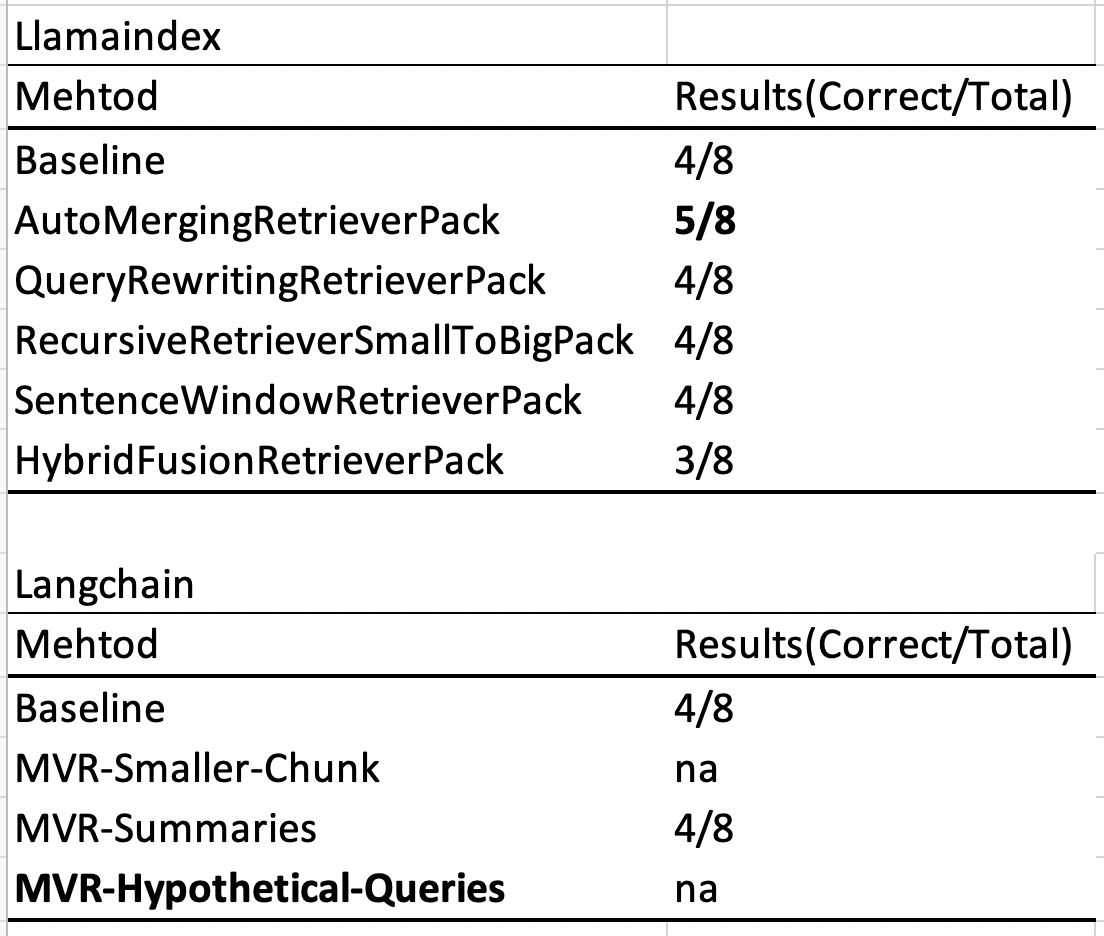